In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import os
import matplotlib.pyplot as plt
import matplotlib
import json
import ptitprince as pt
font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

/usr/local/lib/python3.8/dist-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/usr/local/lib/python3.8/dist-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Data cleaning

### load data and parse in order to retrieve "yes"/"no" answers

In [9]:
class DF(pd.DataFrame):
    def __init__(self, data):
        super().__init__(data=data)

    def avg_ind(self, groups):
        return self.groupby(groups, as_index=False).mean()
    
class Dataset:
    def __init__(self, gpt=None, human=None,
                 gpt_unclear=None, human_unclear=None):
        self.gpt = DF(gpt)
        self.gpt_unclear = DF(gpt_unclear)
        self.human_unclear = DF(human_unclear)
        self.human = DF(human)
        self.all = DF(pd.concat([gpt, human]))


def get_data(path, label=None, human=False):

    df = pd.read_csv(open(path, 'r'))

    # exclude incomplete
    if human:
        df_124 = df.prolific_id.value_counts() == 124
        df = df[df.prolific_id.isin(df_124[df_124].index)]
        # remove controls 
        df = df[df['cond']!='control']
    # else:
        # df_124 = df.iter.value_counts() == 124
        # df = df[df.iter.isin(df_124[df_124].index)]
    if not label:
        df['exp'] = df['cond']
        df['a'] = df['answer']
    else:
        df['exp'] = label
        file = json.load(
            open('data/greene/' + label + '.json', 'r'))
        map_titles_id = {v['id']: v['title'] for v in file}
        df['title'] = df['item_id'].map(map_titles_id)
    
    # exclude the "why?"
    # df = df[df['q_id'] == 0]

    # df['a'] = df['a'].str.lower()

    # parse ("yes", A, or "yes,"")
    df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True, case=False) | df['a'].str.contains(
        pat=r'\b(\(A\))\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(yes,)\b', regex=True, case=False) | df['a'].str.lower().str.startswith(pat='yes,')
    df['no'] = df['a'].str.contains(pat=r'\b(no)\b', regex=True, case=False) | df['a'].str.contains(
        pat=r'\b(\(B\))\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(no,)\b', regex=True, case=False) | df['a'].str.lower().str.startswith(pat='no,')
    

    df['unclear'] = df['yes'] == df['no']
    df['val'] = None
    df.loc[df['yes'] == 1, 'val'] = 'yes'
    df.loc[df['no'] == 1, 'val'] = 'no'
    df.loc[df['unclear'] == 1, 'val'] = 'unclear'
    df.loc[df['q_id']==1, 'val'] = 'na'
    df.loc[df['q_id']==1, 'yes'] = 'na'
    df.loc[df['q_id']==1, 'no'] = 'na'
    df.loc[df['q_id']==1, 'unclear'] = 'na'

    return df[df['unclear'] != 1], df


# ------------------------------------------------------------------------------------- #
# load gpt data
# ------------------------------------------------------------------------------------- #
foldernames_gpt = [
    './GPT3/greene/non_moral-003-last',
    './GPT3/greene/impersonal_moral-003-last',
    './GPT3/greene/personal_moral-003-last'
]
labels = ['non_moral', 'impersonal_moral', 'personal_moral']

dfs = []
dfs_with_unclear = []

for foldername, l in zip(foldernames_gpt, labels):
    d, d_with_unclear = get_data(path=foldername+'/results.csv', label=l)
    dfs.append(d.copy())
    dfs_with_unclear.append(d_with_unclear.copy())


# ------------------------------------------------------------------------------------- #
# load human data
# ------------------------------------------------------------------------------------- #
foldernames_humans = [
    './HUMANS/greene_1.csv',
    './HUMANS/greene_2.csv'
]

dfs_ = []
dfs_with_unclear_ = []

for foldername, l in zip(foldernames_humans, labels):
    d, d_with_unclear = get_data(path=foldername, label=None, human=True)
    dfs_.append(d.copy())
    dfs_with_unclear_.append(d_with_unclear.copy())

ds = Dataset(
    gpt=pd.concat(dfs), gpt_unclear=pd.concat(dfs_with_unclear),
    human=pd.concat(dfs_), human_unclear=pd.concat(dfs_with_unclear_)
)

print('Unclear gpt proportion=' +
      str((ds.gpt_unclear['unclear'] == 1).sum()/len(ds.gpt_unclear[ds.gpt_unclear['q_id']==0])))
print('Unclear human proportion=' +
      str((ds.human_unclear['unclear'] == 1).sum()/len(ds.human_unclear[ds.human_unclear['q_id']==0])))

# ds.gpt[ds.gpt['title']=='sControl']

print('Complete gpt subjects=' + str(sum(ds.gpt_unclear.iter.value_counts()==(120))))
print('Complete human subjects=' + str(sum(ds.human_unclear.prolific_id.value_counts()==(120))))
# ds.human_unclear.to_csv('unclear_greene.csv')
# ds.human_unclear['len'] = ds.human_unclear.a.apply(lambda x: len(x) > 0)
# ds.human_unclear['len'] = ds.human_unclear.a.apply(lambda x: str(len(x) > 0) if isinstance(x, str) else 'type issue')
# df = ds.human_unclear.copy()
# pd.concat([
    # ds.human,
    # ds.gpt]).to_json('all.json', orient='records')

# TODO: clean the human data and gpt data for unclear responses
# TODO: rerun gpt-002 (see why 32 in impersonal and not 36) and see why empty
# TODO: add the gpt data to the human data that is already there
# TODO: what about the "may be" responses"
# TODO: what about the "yrd" responses" (human typo)
# TODO: solve the split issue (last sentence Mrs)
# TODO: solve the encoding issue

# df = pd.concat([
    # ds.human_unclear,
    # ds.gpt_unclear])

# df.to_csv('all.csv')

# load the manually corrected data (yes/no/unclear)
df_final = pd.read_csv('H+GPT3/all_final.csv')
df_final['yes'] = df_final.a0.str.contains('yes')
df_final_dv3 = pd.read_csv('H+GPT3/dv3_all_final.csv')
df_final_dv3['yes'] = df_final_dv3.a0.str.contains('yes')


    

/tmp/ipykernel_154226/3042790548.py:47: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True, case=False) | df['a'].str.contains(
/tmp/ipykernel_154226/3042790548.py:48: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  pat=r'\b(\(A\))\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(yes,)\b', regex=True, case=False) | df['a'].str.lower().str.startswith(pat='yes,')
/tmp/ipykernel_154226/3042790548.py:49: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['no'] = df['a'].str.contains(pat=r'\b(no)\b', regex=True, case=False) | df['a'].str.contains(
/tmp/ipykernel_154226/3042790548.py:50: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  pat=r'\b(\(B\))\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(no,)\b', regex=True, case=False) | df['a'].st

Unclear gpt proportion=0.07777777777777778
Unclear human proportion=0.08333333333333333
Complete gpt subjects=30
Complete human subjects=31


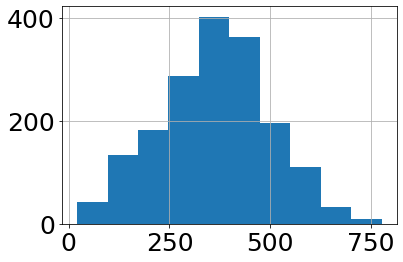

In [19]:
ds.gpt_unclear[ds.gpt_unclear.a_id==1].a.str.len().hist()
pd.concat([ds.gpt_unclear, ds.human_unclear]).to_csv('dv3_all.csv')

### Exclusions based on controls

In [4]:
df = ds.human

controls = df[df['cond']=='control']
#
to_exclude = \
(controls[(controls['title']=='hControl') & (controls['val']!='no')]['prolific_id'].unique().tolist()
+ controls[(controls['title']=='sControl') & (controls['val']!='yes')]['prolific_id'].unique().tolist())
#
df2 = df[~df['prolific_id'].isin(to_exclude)]
df3 = df2[df2['cond']!='control']

ds.human.data = df.copy()

df = ds.gpt

controls = df[df['cond']=='control']
#
to_exclude = \
(controls[(controls['title']=='hControl') & (controls['val']!='no')]['prolific_id'].unique().tolist()
+ controls[(controls['title']=='sControl') & (controls['val']!='yes')]['prolific_id'].unique().tolist())
#
df2 = df[~df['prolific_id'].isin(to_exclude)]
df3 = df2[df2['cond']!='control']

ds.gpt.data = df.copy()


ds.gpt.data.shape

/tmp/ipykernel_171028/1631886545.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ds.human.data = df.copy()


KeyError: 'cond'

In [ ]:
len(ds.human.data['prolific_id'].unique())

31

# Define functions

In [4]:
def raincloud(x, y, markersize, df, order):
    # adding color
    pal = "Set2"
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    means = df.groupby(x)[y].mean().reindex(order)
    sns.scatterplot(x=means.index, y=means, color='white', edgecolor='black', s=150/2, linewidth=1.5, zorder=4)


    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.25, cut=0., linewidth=0, 
                            scale="area", width=1.1, inner=None, orient='v', zorder=1, order=order)

    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1, edgecolor='black', capsize=.1, zorder=3, bw=0, order=order)
    
        
def box_same_color(ax2):
    box_patches = [patch for patch in ax2.patches if type(
        patch) == matplotlib.patches.PathPatch]


    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
        box_patches = ax2.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax2.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax2.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
# 

# Fig 1

/tmp/ipykernel_154226/2761561745.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


60

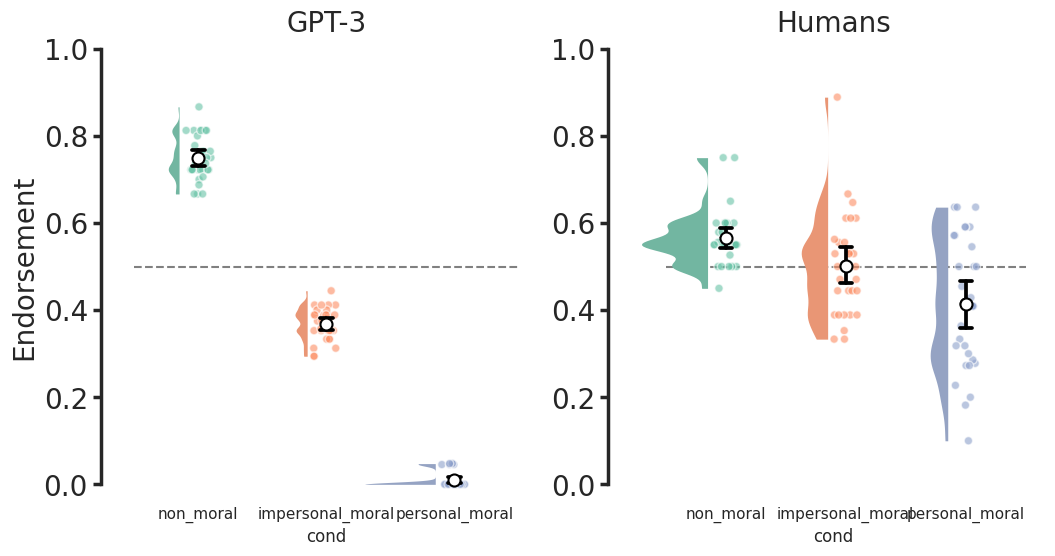

In [13]:
sns.set(
    rc={'figure.figsize':(12,6), "figure.dpi": 100, 'legend.fontsize': 20,
      'xtick.labelsize': 11, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
order = ['non_moral', 'impersonal_moral', 'personal_moral']


# df = ds.gpt.avg_ind(['iter', 'exp'])
df = df_final_dv3[df_final_dv3.source=='AI'].groupby(['sub_id', 'cond'], as_index=False).mean()
plt.subplot(1, 2, 1)
# sns.barplot(x='exp', y='yes', data=df, alpha=.6, errwidth=0, zorder=1, order=order)
# sns.stripplot(x='exp', y='yes', data=df, size=10, linewidth=1.2, zorder=2, edgecolor='white', jitter=True, order=order)
# sns.pointplot(x='exp', y='yes', data=df, color='black',  join=False, ci=68, linewidth=1, edgecolor='white', capsize=0, zorder=3, scale=0, order=order)
raincloud(x='cond', y='yes', markersize=6, df=df, order=order)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.ylim(-.02, 1.02)
plt.ylabel('Endorsement', fontsize=20)
# plt.xticks(labels=order, ticks=[0, 1, 2])
plt.title('GPT-3', fontsize=20)
plt.tick_params(bottom=False)
plt.gca().spines['left'].set_linewidth(2.5)

# plt.xlim(-.02, 1.02)

# 
plt.subplot(1, 2, 2)
# df = ds.human.avg_ind(['prolific_id', 'exp'])

df = df_final_dv3[df_final_dv3.source=='Human'].groupby(['sub_id', 'cond'], as_index=False).mean()
# df = df[df.exp!='control']
# sns.barplot(x='exp', y='yes', data=df, alpha=.6, errwidth=0, zorder=1, order=order)
# sns.stripplot(x='exp', y='yes', data=df, size=10, linewidth=1.2, zorder=2, edgecolor='white', jitter=True, order=order)
# sns.pointplot(x='exp', y='yes', data=df, color='black',  join=False, ci=68, linewidth=1, edgecolor='white', capsize=0, zorder=3, scale=0, order=order)
raincloud(x='cond', y='yes', markersize=6, df=df, order=order)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.ylim(-.02, 1.02)
# plt.ylim(-.02, 3.02)
# plt.xlim(-.52, 3.52)
plt.ylabel('')
plt.title('Humans', fontsize=20)
# plt.xticks(labels=order, ticks=[0, 1, 2])
plt.tick_params(bottom=False)
#
sns.despine(offset=10, trim=True, bottom=True)
plt.gca().spines['left'].set_linewidth(2.5)

# df.groupby('exp').yes.mean()

df_final_dv3.groupby('sub_id').size().max()

ValueError: Could not interpret value `val` for parameter `x`

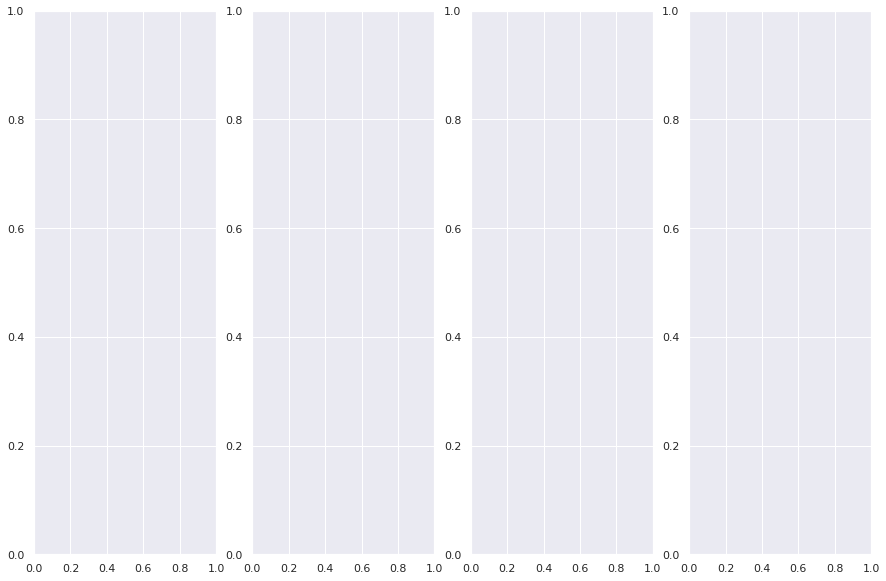

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})

exp = df['exp'].unique()
# df = df[df['unclear']!=1]
fig, axes = plt.subplots(nrows=1, ncols=len(exp))
# Draw a nested barplot by species and sex
for e, ax in zip(exp, axes.flat):
    sns.histplot(
        x='val', data=df[df['exp']==e], hue='val', hue_order=['yes', 'no', 'unclear'], stat='probability', alpha=.8, ax=ax)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0, 11)/10)
    ax.set_title(e)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)